# Regression Trees
### by [Jason DeBacker](https://jasondebacker.com), October 2025

This notebook provides an example estimating regression trees in Python using the `sckikit-learn` package.  It follows some of the material in James, et al (2013, Ch. 8). We will build up from basic decision trees used for regression problems to the methods of Bagging, Random Forests and Boosting.  These methods up use recover more robust trees.

## 1. Set up

We will use `scikit-learn`, importing a number of useful  modules and functions to be used below.

Our example data will be the PSID data used in Problem Set 4.  Here, we'll use regression trees to predict wages.

In [1]:
# imports
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# read in data
data_file_path = os.path.join('..', 'Optimization', 'PSID_data.dta')
psid = pd.read_stata(data_file_path,
                     columns=['id68', 'year', 'hannhrs', 'hlabinc', 'hsex',
                              'hyrsed', 'age', 'hrace'])

# create wages and ln(wages)
# note need to be careful with wages = 0
psid['wage'] = psid['hlabinc'] / psid['hannhrs']
psid['ln_wage'] = np.log(psid['wage'])

# sample selection
# just men
psid.drop(psid[psid.hsex != 1].index, inplace=True)
# just ages 25-60
psid.drop(psid[psid.age > 60].index, inplace=True)
psid.drop(psid[psid.age < 25].index, inplace=True)
# just those above min wage
psid.drop(psid[psid.wage < 7].index, inplace=True)
psid.drop(psid[psid.wage == np.inf].index, inplace=True)

# create dummy variables for race
psid['black'] = (psid['hrace'] == 2).astype(int)
psid['hispanic'] = (psid['hrace'] == 5).astype(int)
psid['other'] = (
    (psid['hrace'] == 3) | (psid['hrace'] == 4) |
    (psid['hrace'] == 6) | (psid['hrace'] == 7)).astype(int)

# drop obs if missing values for any variables of interest
psid.dropna(axis=0,
            subset=['ln_wage', 'hyrsed', 'age', 'black', 'other'],
            inplace=True)
# just keep year 2000 data
psid = psid[psid.year == 2000]
# drop columns we won't want to use
psid.drop(
    ['id68', 'year', 'hlabinc', 'hrace', 'wage', 'hispanic', 'hsex'],
    axis=1,
    inplace=True)
psid.describe()

,hannhrs,hyrsed,age,ln_wage,black,other
count,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000,2595.000000
mean,2259.263672,13.901734,41.228901,3.117215,0.052408,0.032755
std,597.081787,2.091760,9.405457,0.605962,0.222892,0.178030
min,104.000000,4.000000,25.000000,1.958722,0.000000,0.000000
25%,1980.000000,12.000000,33.000000,2.704646,0.000000,0.000000
50%,2200.000000,14.000000,41.000000,3.063443,0.000000,0.000000
75%,2550.000000,16.000000,49.000000,3.448278,0.000000,0.000000
max,4900.000000,17.000000,60.000000,6.266819,1.000000,1.000000


In [3]:
# create y and X to reference later
y = psid['ln_wage'].values
X_var_names = ['hannhrs', 'hyrsed', 'age', 'black', 'other']
X = psid[X_var_names].values

## 2. Basic Decision Tree

Here, we'll fit a decision tree on the full data using the `DecisionTreeRegressor()` function.

In [4]:
# Fit a decision tree on the full data
dtr = tree.DecisionTreeRegressor()
wage_tree = dtr.fit(X, y)

In [5]:
# predict a value from the tree
wage_tree.predict([[1200, 12, 36, 0, 0]]) # list is the values for the 5 variables in order

array([3.50422049])

In [6]:
# print out text representation of the tree
r = export_text(wage_tree, feature_names=X_var_names)
print(r)

|--- hyrsed <= 15.50
|   |--- age <= 35.50
|   |   |--- hyrsed <= 13.50
|   |   |   |--- hannhrs <= 146.00
|   |   |   |   |--- value: [4.91]
|   |   |   |--- hannhrs >  146.00
|   |   |   |   |--- age <= 30.50
|   |   |   |   |   |--- hyrsed <= 11.50
|   |   |   |   |   |   |--- hannhrs <= 1391.60
|   |   |   |   |   |   |   |--- hannhrs <= 640.00
|   |   |   |   |   |   |   |   |--- value: [2.45]
|   |   |   |   |   |   |   |--- hannhrs >  640.00
|   |   |   |   |   |   |   |   |--- age <= 28.50
|   |   |   |   |   |   |   |   |   |--- value: [3.01]
|   |   |   |   |   |   |   |   |--- age >  28.50
|   |   |   |   |   |   |   |   |   |--- value: [2.98]
|   |   |   |   |   |   |--- hannhrs >  1391.60
|   |   |   |   |   |   |   |--- hannhrs <= 3115.60
|   |   |   |   |   |   |   |   |--- hannhrs <= 2833.90
|   |   |   |   |   |   |   |   |   |--- hannhrs <= 2709.40
|   |   |   |   |   |   |   |   |   |   |--- age <= 29.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated bran

## That's a big tree!!

This is more than we want.  Let's do this again, but limit the size of the tree using the `max_depth` argument:

In [7]:
# Fit a decision tree on the full data
dtr3 = tree.DecisionTreeRegressor(max_depth=3)
wage_tree3 = dtr3.fit(X, y)
r = export_text(wage_tree3, feature_names=X_var_names)
print(r)

|--- hyrsed <= 15.50
|   |--- age <= 35.50
|   |   |--- hyrsed <= 13.50
|   |   |   |--- value: [2.75]
|   |   |--- hyrsed >  13.50
|   |   |   |--- value: [2.95]
|   |--- age >  35.50
|   |   |--- hyrsed <= 12.50
|   |   |   |--- value: [2.95]
|   |   |--- hyrsed >  12.50
|   |   |   |--- value: [3.15]
|--- hyrsed >  15.50
|   |--- age <= 31.50
|   |   |--- hannhrs <= 2857.50
|   |   |   |--- value: [3.13]
|   |   |--- hannhrs >  2857.50
|   |   |   |--- value: [2.66]
|   |--- age >  31.50
|   |   |--- hannhrs <= 3081.00
|   |   |   |--- value: [3.54]
|   |   |--- hannhrs >  3081.00
|   |   |   |--- value: [3.20]



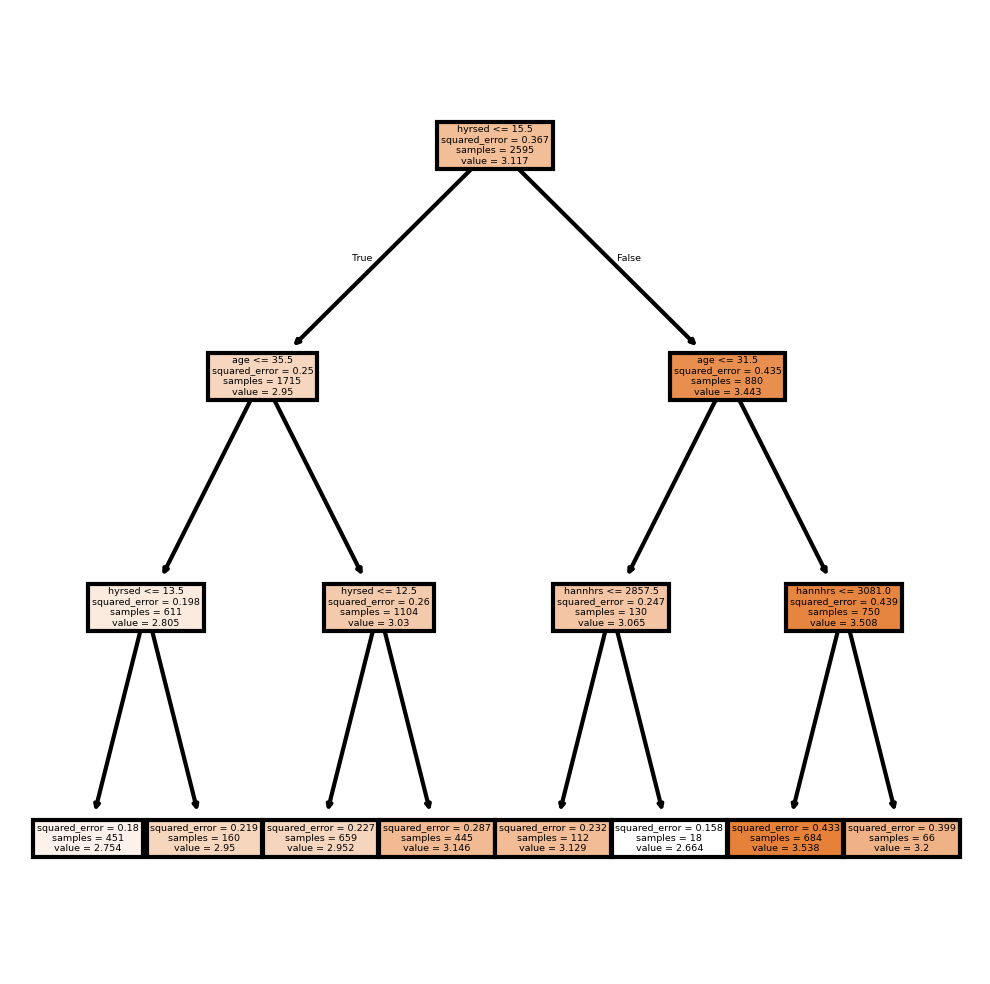

In [8]:
# we can also plot the tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(wage_tree3,
           feature_names = X_var_names,
           filled = True);

In [9]:
# What about fit?
MSE = mean_squared_error(y, wage_tree.predict(X))
MSE3 = mean_squared_error(y, wage_tree3.predict(X))
print('The SSE of a tree of depth 3  and ',
      wage_tree3.get_n_leaves(), ' leaves = ', MSE3)
print('The SSE of a tree of depth ', wage_tree.get_depth(), ' and ',
      wage_tree.get_n_leaves(), ' leaves = ', MSE)

The SSE of a tree of depth 3  and  8  leaves =  0.2870818003026425
The SSE of a tree of depth  32  and  2433  leaves =  0.012063987273423482


## 3. Bagging

Recall that bagging is the process of bootstrapping samples, estimating the tree on each, then averaging across the bagged samples to form predicted values.  The `sckit-learn` packages has a [`BaggingRegressor()`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) function for regression trees and a [`BaggingClassifier()`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) function for classification trees. These methods are called "ensemble" methods because they average an "ensemble" or collection of trees. Ensemble methods are a theme in predictive models and machine learning.

Let's do a bagged version of our `max_depth=3` regression tree.

In [10]:
# Bagging
wage_treeB = BaggingRegressor(
    tree.DecisionTreeRegressor(max_depth=3), # here you specify whether regession or classfication problem
    n_estimators=53, # how samples to draw, B
    max_samples=1000,  # number of observations in each sample
    bootstrap=True,  # whether draw with replacement
    oob_score=True,  # whether to estimate the test error
    random_state=25,  # sets random state so can replicate this result
    n_jobs=4) # how many bags to do at once (parallel processing)
wage_treeB.fit(X, y)

y_predB = wage_treeB.oob_prediction_
MSE_B = mean_squared_error(y, y_predB)
print('MSE=', MSE_B)

MSE= 0.2886903508956769


Let's plot the MSE of the bagging ensemble method as a function of the max depth of the trees in order to estimate the optimal size of the tree.  Remember that more depth will allow for a better fit in sample, but can lead to overfitting.

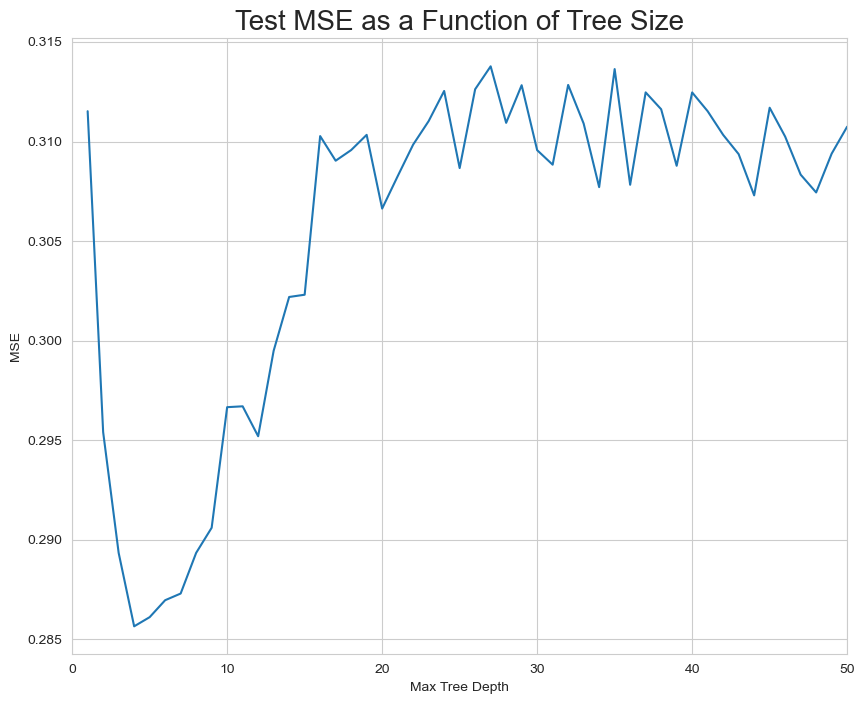

In [11]:
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

max_max_depth = 50
depth_vec = np.arange(1, max_max_depth + 1)
MSE_vec = np.zeros(max_max_depth)
for i in depth_vec:
    wage_tree_loop = BaggingRegressor(
        tree.DecisionTreeRegressor(max_depth=i),
        n_estimators=50,
        max_samples=1000,
        bootstrap=True,
        oob_score=True)
    wage_tree_loop.fit(X, y)
    y_pred_loop = wage_tree_loop.oob_prediction_
    MSE_vec[i - 1] = mean_squared_error(y, y_pred_loop)

plt.plot(depth_vec, MSE_vec)
plt.title('Test MSE as a Function of Tree Size', fontsize=20)
plt.xlabel(r'Max Tree Depth')
plt.ylabel(r'MSE')
plt.xlim((0, max(depth_vec)))
plt.show()

## 4. Random Forests
Bagging solves the problem of sensitivity of the estimated trees to the sample drawn for the training set by taking many samples and averaging the predictions. However, bagging does not solve the issue that the trees' structure in each sample will be correlated due to the trees using the same group of features in each sample. Random forest decision trees add one more layer of randomization that reduces the correlation in the trees that comes from a constant feature set.

A random forest continues the bagging (bootstrapping) approach, but causes each tree from a sample of observations to have a randomly determined subset of features. In other words, each tree can only use a small subset of features. The intuition is the following. Randomizing the features allows us to better explore the full set of possible predictors. A typical number of features $m$ to limit each tree to use is $m=\sqrt{P}$. This may require more bootstrapped (bagging) draws, but random forests have been shown to have better predictive accuracy than bagging alone.

`Scikit-learn` also has functions to execute random forests. [`RandomForestRegressor()`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) estimates a random forest decision tree regression model, and [`RandomForestClassifier()`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) estimates a random forest decision tree classifier model.

In [12]:
wage_treeRF = RandomForestRegressor(
    max_depth=3,  # set max depth of tree
    n_estimators=100,
    max_features=3,  # number of features to consider when looking for the best split
    bootstrap=True,
    n_jobs=-1,
    oob_score=True,
    random_state=25)
wage_treeRF.fit(X, y)

y_predRF = wage_treeRF.oob_prediction_
MSE_RF = mean_squared_error(y, y_predRF)
print('MSE=', MSE_RF)

MSE= 0.2874267784990247


Let's compare the baseline MSE, versus the bagging MSE, versus the random forest MSE as a function of depth of the trees.

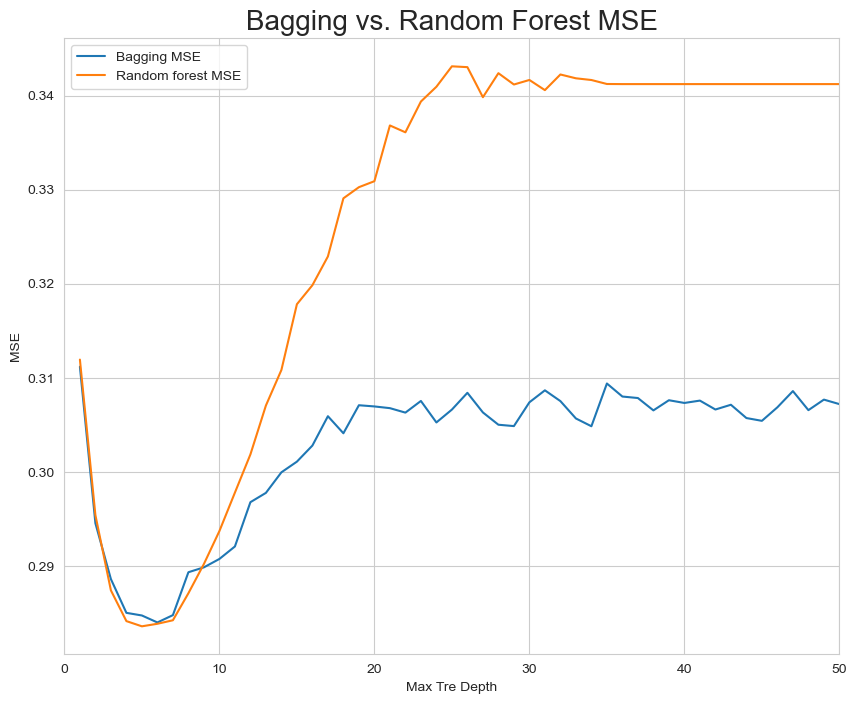

In [13]:
max_max_depth = 50
depth_vec = np.arange(1, max_max_depth + 1)
MSE_B_vec = np.zeros(max_max_depth)
MSE_RF_vec = np.zeros(max_max_depth)
for i in depth_vec:
    wage_treeRF_loop = RandomForestRegressor(
        max_depth=i,  # set max depth of tree
        n_estimators=100,
        max_features=3,  # number of features to consider when looking for the best split
        bootstrap=True,
        oob_score=True,
        random_state=25)
    wage_treeRF_loop.fit(X, y)
    y_pred_loop = wage_treeRF_loop.oob_prediction_
    MSE_RF_vec[i - 1] = mean_squared_error(y, y_pred_loop)

    wage_treeB_loop = BaggingRegressor(
        tree.DecisionTreeRegressor(max_depth=i),
        n_estimators=100,
        max_samples=1000,
        bootstrap=True,
        oob_score=True)
    wage_treeB_loop.fit(X, y)
    y_pred_loop = wage_treeB_loop.oob_prediction_
    MSE_B_vec[i - 1] = mean_squared_error(y, y_pred_loop)

fig, ax = plt.subplots()
plt.plot(depth_vec, MSE_B_vec, label='Bagging MSE')
plt.plot(depth_vec, MSE_RF_vec, label='Random forest MSE')
plt.title('Bagging vs. Random Forest MSE', fontsize=20)
plt.xlabel(r'Max Tre Depth')
plt.ylabel(r'MSE')
plt.xlim((0, max(depth_vec)))
plt.legend(loc='best')

## 4. Boosting

Boosting is another approach to estimating more robust trees (i.e., trees with better out of sample fit).  Boosting does not rely on bootstraping the data. Rather, the boosting algorithm uses a sequence of small trees, fit on the residuals from teh fitted values on the tree estimated on the prior iteration.  Thus, at each iteration, small trees are created to update the predictions slowly.

`scikit-learn` has several booting methods availableo (see them in the list of ensemble methods [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble).  Below, we'll illustrate how to use the `GradientBoostingRegressor` function.  Note that Boosting method doesn't allow you to choose max tree size in the end - only at each iteration.  So below we'll iterate over max leaves allowed in the trees.

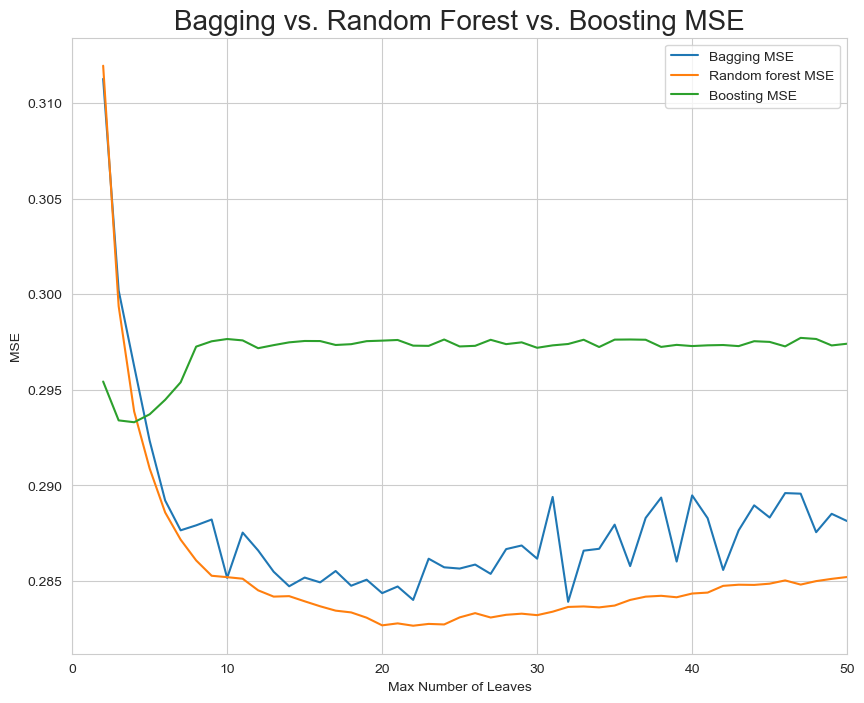

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=9)
max_leaves = 50
leaves_vec = np.arange(2, max_leaves + 1)
# MSE_Bag_vec = np.zeros_like(leaves_vec)
# MSE_Boost_vec = np.zeros_like(leaves_vec)
# MSE_RF_vec = np.zeros_like(leaves_vec)
MSE_Bag_vec, MSE_Boost_vec, MSE_RF_vec = [], [], []
for i, v in enumerate(leaves_vec):
    wage_treeRF_loop = RandomForestRegressor(
        max_leaf_nodes=v,  # set max depth of tree
        n_estimators=100,
        max_features=3,  # number of features to consider when looking for the best split
        bootstrap=True,
        oob_score=True,
        random_state=25)
    wage_treeRF_loop.fit(X, y)
    y_pred_loop = wage_treeRF_loop.oob_prediction_
#     MSE_RF_vec[i] = ((y - y_pred_loop) ** 2).sum()
#     MSE_RF_vec[i] = mean_squared_error(y, y_pred_loop)
    MSE = mean_squared_error(y, y_pred_loop)
    MSE_RF_vec.append(MSE)

    wage_treeBag_loop = BaggingRegressor(
        tree.DecisionTreeRegressor(max_leaf_nodes=v),
        n_estimators=50,
        max_samples=1000,
        bootstrap=True,
        oob_score=True)
    wage_treeBag_loop.fit(X, y)
    y_pred_loop = wage_treeBag_loop.oob_prediction_
#     MSE_Bag_vec[i] = ((y - y_pred_loop) ** 2).sum()
#     MSE_Bag_vec[i] = mean_squared_error(y, y_pred_loop)
    MSE = mean_squared_error(y, y_pred_loop)
    MSE_Bag_vec.append(MSE)

    # Boosting methods don't have out of sample predictions
    # by default - we need to explicitly do CV
    n_splits = 5 # number of folds for k-fold CV
    cv = KFold(n_splits=n_splits)
    wage_treeBoost_loop = GradientBoostingRegressor(
        learning_rate=0.1,
        max_depth=3,
        max_leaf_nodes=v,
        n_estimators=50,
    )
    SSE = 0
    # Now fit and test on all folds
    for train, test in cv.split(X_train, y_train):
        wage_treeBoost_loop.fit(X_train[train], y_train[train])
#         SSE += ((y_train[test] - wage_treeBoost_loop.predict(X_train[test])) ** 2).sum()
        SSE += mean_squared_error(y_train[test], wage_treeBoost_loop.predict(X_train[test]))
#     MSE_Boost_vec[i] = SSE / n_splits
    MSE = SSE / n_splits
    MSE_Boost_vec.append(MSE)

fig, ax = plt.subplots()
plt.plot(leaves_vec, MSE_Bag_vec, label='Bagging MSE')
plt.plot(leaves_vec, MSE_RF_vec, label='Random forest MSE')
plt.plot(leaves_vec, MSE_Boost_vec, label='Boosting MSE')
plt.title('Bagging vs. Random Forest vs. Boosting MSE', fontsize=20)
plt.xlabel(r'Max Number of Leaves')
plt.ylabel(r'MSE')
plt.xlim((0, max(depth_vec)))
plt.legend(loc='best')

## References
* James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani, [*An Introduction to Statistical Learning with Applications in R*](http://link.springer.com.proxy.uchicago.edu/book/10.1007%2F978-1-4614-7138-7), New York, Springer (2013).